In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans

We first read G, the graph of users and edges (this is unlabelled, but w/ the same IDs as the users_neighb csv)

In [2]:
data_dir = "../twitter_data/"

In [14]:
G = nx.read_graphml(os.path.join(data_dir, "users_clean.graphml"))

In [17]:
G.number_of_nodes(), G.number_of_edges()

(100386, 2286592)

In [5]:
users_feat = pd.read_csv(os.path.join(data_dir, 'users_neighborhood_anon.csv'))

In [56]:
G.in_degree['9']

57

In [39]:
twits = pd.read_csv(os.path.join(data_dir, 'tweets.csv'))

In [41]:
twits.columns

Index(['user_id', 'screen_name', 'tweet_id', 'tweet_text', 'tweet_creation',
       'tweet_fav', 'tweet_rt', 'rp_flag', 'rp_status', 'rp_user', 'qt_flag',
       'qt_status_id', 'qt_user_id', 'qt_text', 'qt_creation', 'qt_fav',
       'qt_rt', 'rt_flag', 'rt_status_id', 'rt_user_id', 'rt_text',
       'rt_creation', 'rt_fav', 'rt_rt'],
      dtype='object')

## Clustering of the GloVe vectors

In [64]:
glove_cols = users_feat.columns[users_feat.columns.str.contains("glove")][:300]

In [70]:
glovects = users_feat[glove_cols].values

glovects[np.isnan(glovects)] = 0

In [91]:
N_Clusters = 50

In [92]:
kmeans = KMeans(n_clusters=N_Clusters).fit(glovects)

(array([ 8528.,  8279.,  2983., 19431.,  8154., 14752., 16434.,  2590.,
         9345.,  9890.]),
 array([ 0. ,  4.9,  9.8, 14.7, 19.6, 24.5, 29.4, 34.3, 39.2, 44.1, 49. ]),
 <a list of 10 Patch objects>)

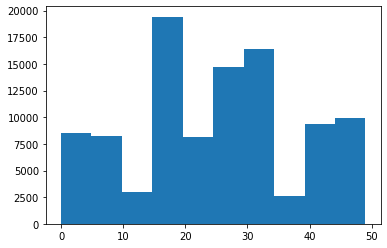

In [97]:
plt.hist(kmeans.labels_)

In [99]:
G_glove = G.copy()
for i in range(N_Clusters):
    G_glove.add_node('fake_'+str(i))
for j in range(len(kmeans.labels_)):
    G_glove.add_edge(str(j), 'fake_'+str(kmeans.labels_[j]))
    G_glove.add_edge('fake_'+str(kmeans.labels_[j]),str(j))


In [107]:
nx.write_graphml(G_glove, "G_glove.graphml")

In [108]:
G_glove.clear()

## Timestamps


First of all, since the graph is anonymized but the tweets are not, we will make a dictionary between real user IDs and anonymous user IDs

In [155]:
dd = pd.read_csv("../twitter_data/users_neighborhood.csv", usecols=['user_id', 'user_id_original'])

In [161]:
anom_to_origin = dict(dd.values)
origin_to_anom = {a:b for b,a in anom_to_origin.items()}

In [162]:
only_tweets = twits[(twits.rp_flag == False) & (twits.rt_flag == False) & (twits.qt_flag == False)].sort_values("tweet_creation")

In [169]:
N = len(only_tweets)
num_new_nodes = 100
k = int(N/num_new_nodes)

In [174]:
G_time = G.copy()

In [176]:
for i in range(num_new_nodes):
    G_time.add_node('fake_'+str(i))

In [177]:
for i in range(num_new_nodes):
    print(i)
    slice = only_tweets[i*k:(i+1)*k]
    for j in slice.user_id:
        G_time.add_edge(str(origin_to_anom[j]),'fake_'+str(i))
        G_time.add_edge('fake_'+str(i), str(origin_to_anom[j]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [178]:
nx.write_graphml(G_time, "G_time.graphml")

### Why not intervals of the same length?

In [118]:
twits.tweet_creation.min()

1166330873.0

In [119]:
twits.tweet_creation.max()

1509551282.0

In [120]:
from datetime import datetime

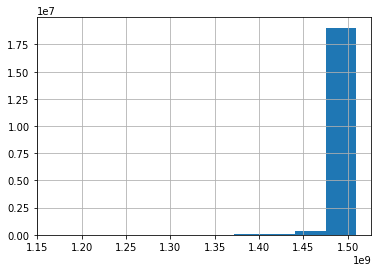

In [179]:
twits.tweet_creation.hist()

In [122]:
datetime.fromtimestamp(1509551282.0), datetime.fromtimestamp(1166330873.0)

(datetime.datetime(2017, 11, 1, 11, 48, 2),
 datetime.datetime(2006, 12, 16, 23, 47, 53))